# Personalized recommendation

# Project Outline: User–User Collaborative Filtering with Purchases (Implicit Feedback)
 **item–item similarity**

item_similarity matrix is built from the user–item interaction matrix.
Each column is an item vector showing which users bought it (and how strongly, e.g. with log1p weights).
To compute similarity between two items, you compare those columns.
👉 So two items will have high cosine similarity if:
Many of the same users bought both, and
Their purchase patterns (weights) are similar.

## 1) Goal

Recommend items to users, using only **purchase (0/1) histories**.


### 🔹 User similarity (user–user CF)

* Two users are considered **similar** if they **interacted with the same items in similar ways**.
* You compare **rows** of the user–item matrix.
* Example: if Alice and Bob both bought mostly the same products, their vectors look alike → high similarity.

---

### 🔹 Item similarity (item–item CF)

* Two items are considered **similar** if they are **consumed by the same users**.
* You compare **columns** of the user–item matrix.
* Example: if product A and product B are often bought by the same customers, their vectors look alike → high similarity.

---

### 🔹 How is it calculated?

* The most common way is **cosine similarity**:

$$
\text{sim}(i,j) = \frac{ \sum_{u} r_{u,i} \, r_{u,j} }{ \sqrt{\sum_{u} r_{u,i}^2} \cdot \sqrt{\sum_{u} r_{u,j}^2} }
$$

* Here, $r_{u,i}$ is the interaction weight of user $u$ with item $i$.
* Intuition: similarity is **high** if the *same users* interacted with both items, especially with similar intensity.

---

### 🔹 Concept in words

* **User similarity**: “Find other people who behave like me, then recommend what they bought.”
* **Item similarity**: “Find products that behave alike across customers, then recommend them to me based on what I bought.”




In [19]:
import pandas as pd

cols = ['shopUserId', 'orderId', 'quantity', 'groupId', 'created']
tx = pd.read_csv('../data/processed//transactions_clean.csv', usecols=cols + ['status'], low_memory=False)
tx = tx[tx['status'] == 'active'].copy()
tx = tx[cols]  # Drop the 'status' column after filtering
tx[['quantity']] = tx[['quantity']].astype(int)
tx


,shopUserId,orderId,quantity,groupId,created
0,812427,785001,1,261873,2025-08-05 20:14:28
1,831360,784985,4,261745,2025-08-05 19:55:36
2,209204,784978,1,265298,2025-08-05 19:47:22
4,831340,784977,1,260596,2025-08-05 19:46:09
5,831340,784977,1,260596,2025-08-05 19:46:09
...,...,...,...,...,...
250024,78202,158870,1,221416,2024-05-22 14:18:16
250026,78181,158841,1,265843,2024-05-22 13:42:39
250038,78145,158800,1,261518,2024-05-22 12:54:51
250039,78136,158791,1,542087,2024-05-22 12:44:01


In [20]:
# Aggregate in case same user bought the same product multiple times
# now quantity = total number of units this user has ever bought of this product
user_item = tx.groupby(["shopUserId", "orderId", "groupId", "created"], as_index=False)["quantity"].sum() 
user_item

,shopUserId,orderId,groupId,created,quantity
0,78135,158790,291294,2024-05-22 12:38:29,1
1,78136,158791,542087,2024-05-22 12:44:01,1
2,78145,158800,261518,2024-05-22 12:54:51,1
3,78162,373310,404269,2024-10-24 08:30:27,1
4,78162,437994,291278,2024-11-27 08:57:02,1
...,...,...,...,...,...
126319,831187,784804,210765,2025-08-05 16:49:23,2
126320,831202,784819,250124,2025-08-05 17:04:48,1
126321,831331,784955,270610,2025-08-05 19:25:58,1
126322,831340,784977,260596,2025-08-05 19:46:09,2


# user has stronger signal for items they bought more often

In [21]:
import numpy as np
user_item["interaction"] = np.log1p(user_item["quantity"])
user_item = user_item.drop(columns=["quantity"])

In [22]:
user_item.sort_values(by="groupId", ascending=False)

,shopUserId,orderId,groupId,created,interaction
94916,663375,608264,598005,2025-03-03 07:39:46,0.693147
71615,519916,454520,598005,2024-12-01 14:56:38,1.386294
86082,623574,566754,598005,2025-02-02 19:15:22,0.693147
66719,477266,632100,598005,2025-03-20 16:02:03,0.693147
111696,742803,691723,598005,2025-05-08 08:24:09,0.693147
...,...,...,...,...,...
124769,824043,777233,12025SE,2025-07-30 08:56:36,0.693147
125993,830533,784129,12025SE,2025-08-05 09:38:15,0.693147
124375,818901,778194,106065,2025-07-30 23:25:17,0.693147
124678,822619,775748,106065,2025-07-29 08:37:57,0.693147


In [23]:
# Last-order holdout where ONLY multi-order users go to TEST; single-order users stay in TRAIN
import pandas as pd

df = user_item.copy()
df["created"] = pd.to_datetime(df["created"])

# Order-level timestamps
orders = df.groupby(["shopUserId","orderId"], as_index=False)["created"].max()

# Keep only users with ≥2 orders for TEST
multi_users = orders.groupby("shopUserId")["orderId"].nunique()
multi_users = multi_users[multi_users >= 2].index

# Pick each multi-order user's last order
last_orders = (
    orders[orders["shopUserId"].isin(multi_users)]
    .sort_values("created")
    .groupby("shopUserId", as_index=False)
    .tail(1)[["shopUserId","orderId"]]
)

# Split
test_df  = df.merge(last_orders, on=["shopUserId","orderId"], how="inner")
train_df = df.drop(test_df.index)

print("TRAIN:", train_df.shape, "TEST:", test_df.shape)

TRAIN: (113201, 5) TEST: (13123, 5)


# 
 **Why use LabelEncoder for user and item IDs?**
# 
Libraries like `scipy.sparse.coo_matrix` and `NearestNeighbors` require user and item indices to be consecutive integers starting from 0. However, our original IDs (`shopUserId` and `groupId`) are large, non-consecutive numbers. 
# 
 `LabelEncoder` transforms these IDs into dense integer indices (`user_idx` and `item_idx`), mapping each unique user and item to a unique integer in `[0, n-1]`. This makes it possible to efficiently construct and work with sparse user–item matrices for collaborative filtering.


In [24]:
from sklearn.preprocessing import LabelEncoder

# Fit encoders on TRAIN only
user_enc = LabelEncoder().fit(train_df["shopUserId"])
item_enc = LabelEncoder().fit(train_df["groupId"])

# User index → original user ID
idx_to_user = dict(zip(range(len(user_enc.classes_)), user_enc.classes_))

# Item index → original product ID
idx_to_item = dict(zip(range(len(item_enc.classes_)), item_enc.classes_))

# (optional) inverse: original ID → index
user_to_idx = {u: i for i, u in idx_to_user.items()}
item_to_idx = {i: j for j, i in idx_to_item.items()}


# Encode train
train_df["user_idx"] = user_enc.transform(train_df["shopUserId"])
train_df["item_idx"] = item_enc.transform(train_df["groupId"])

# Encode test, drop unseen users/items
mask = test_df["shopUserId"].isin(user_enc.classes_) & test_df["groupId"].isin(item_enc.classes_)
test_df = test_df.loc[mask].copy()

test_df["user_idx"] = user_enc.transform(test_df["shopUserId"])
test_df["item_idx"] = item_enc.transform(test_df["groupId"])

# Decode later
#recommended_items = [idx_to_item[i] for i in top_item_indices]

In [25]:
train_df.sort_values(by="interaction", ascending=False)

,shopUserId,orderId,groupId,created,interaction,user_idx,item_idx
104603,707428,654239,261916,2025-04-07 08:11:38,3.044522,41902,426
107500,722298,669918,549005,2025-04-22 10:16:29,2.995732,43479,1060
118676,777342,728010,261637,2025-06-06 17:30:52,2.944439,49530,343
55212,411749,335374,261920,2024-10-04 08:06:46,2.833213,17936,427
110321,738782,687487,260951,2025-05-05 15:17:39,2.772589,44984,235
...,...,...,...,...,...,...,...
55259,411950,335631,260224,2024-10-04 09:57:04,0.693147,17961,136
55258,411944,335623,292789,2024-10-04 09:48:18,0.693147,17960,777
55257,411944,335623,291120,2024-10-04 09:48:18,0.693147,17960,740
55256,411944,335623,270452,2024-10-04 09:48:18,0.693147,17960,564


In [26]:
from scipy.sparse import csr_matrix
import numpy as np

X_train = csr_matrix(
    (train_df["interaction"].values,
     (train_df["user_idx"].values, train_df["item_idx"].values)),
    shape=(len(user_enc.classes_), len(item_enc.classes_)),
    dtype=np.float32
)

In [27]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(X_train.T)

distances, indices = knn.kneighbors(X_train.T, n_neighbors=75)

In [28]:
# Drop the self-neighbor (first column)
distances, indices = distances[:, 1:], indices[:, 1:]

In [29]:
# Convert distances to similarities
similarities = 1.0 - distances

In [30]:
# Keep the neighbor indices and their similarities
neighbors_idx = indices
neighbors_sim = similarities

## given the list of items in a user’s basket, sums up the neighbor similarities to generate candidate scores.

In the adjustment I suggested, each candidate item’s similarity contributions are **scaled down by a popularity penalty**:


  * $1 / \log(1 + \text{pop}(j))$ → softer penalty

In [37]:
# Precompute once
Xb = X_train.copy(); Xb.data[:] = 1.0
Xcsc = X_train.copy(); Xcsc.data[:] = 1.0; Xcsc = Xcsc.tocsc()
item_pop = np.asarray(Xb.sum(axis=0)).ravel()                 # #buyers per item
pop_penalty = 1.0 / np.log1p(np.maximum(item_pop, 1))         # 1 / log(1 + pop)



In [38]:
# Preconditions (done once):

MIN_OVERLAP = 10   # require many shared buyers
ALPHA = 150        # shrink tiny overlaps (tune 50–200)

def recommend_for_basket(basket_items, top_n=10):
    scores = np.zeros(X_train.shape[1], dtype=np.float32)
    seen = set(basket_items)
    for i in basket_items:
        js   = neighbors_idx[i]
        sims = neighbors_sim[i]
        ov   = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()   # shared buyers
        keep = ov >= MIN_OVERLAP
        if keep.any():
            # overlap-weighted similarity * soft popularity penalty
            w = (ov[keep] / (ov[keep] + ALPHA)) * pop_penalty[js[keep]]
            scores[js[keep]] += sims[keep] * w
    # don’t recommend items already in basket
    for i in seen:
        scores[i] = -np.inf
    top = np.argpartition(scores, -top_n)[-top_n:]
    return top[np.argsort(scores[top])[::-1]]


In [39]:
import numpy as np

K = 10
hits = 0
total = 0

for oid, g in test_df.groupby("orderId"):
    items = g["item_idx"].unique().tolist()
    if len(items) < 2:  # need context + target
        continue
    target = items[0]                 # or: np.random.choice(items)
    context = [i for i in items if i != target]
    rec = recommend_for_basket(context, top_n=K)
    hits += int(target in rec)
    total += 1

hitrate = hits / max(total, 1)
print(f"HitRate@{K}: {hitrate:.3f}  (orders evaluated: {total})")


HitRate@10: 0.274  (orders evaluated: 2513)


In [40]:
# filtered neighbor counts using your MIN_OVERLAP
Xb = X_train.copy(); Xb.data[:] = 1.0
Xcsc = Xb.tocsc()

MIN_OVERLAP = 10  # same as in your scorer
filtered_counts = np.zeros(X_train.shape[1], dtype=int)

for i in range(X_train.shape[1]):
    js = neighbors_idx[i]
    if js is None or len(js) == 0:
        filtered_counts[i] = 0
        continue
    ov = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()
    filtered_counts[i] = int((ov >= MIN_OVERLAP).sum())

print(f"Items with 0 neighbors (filtered): {(filtered_counts==0).sum()} / {len(filtered_counts)} "
      f"({(filtered_counts==0).mean():.1%})")
print("Median neighbors/item (filtered):", np.median(filtered_counts))
print("10th pct:", np.percentile(filtered_counts, 10))
print("90th pct:", np.percentile(filtered_counts, 90))


Items with 0 neighbors (filtered): 856 / 1097 (78.0%)
Median neighbors/item (filtered): 0.0
10th pct: 0.0
90th pct: 9.0


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

def pick_seed_with_legit_neighbors(Xcsc, neighbors_idx, MIN_OVERLAP, max_tries=500):
    n_items = len(neighbors_idx)
    for _ in range(max_tries):
        i = int(rng.integers(0, n_items))
        js = neighbors_idx[i]
        if js is None or len(js) == 0: 
            continue
        ov = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()
        if (ov >= MIN_OVERLAP).any():
            return i
    # fallback: first item that has any neighbors
    for i in range(n_items):
        js = neighbors_idx[i]
        if js is not None and len(js) > 0:
            return i
    return 0

def visualize_recs_for_single_item(seed_item=None, top_n=10):
    # pick a seed with legit neighbors if none provided
    if seed_item is None:
        seed_item = pick_seed_with_legit_neighbors(Xcsc, neighbors_idx, MIN_OVERLAP)

    # get recs for a one-item basket
    rec_idx = recommend_for_basket([seed_item], top_n=top_n)

    # compute per-edge contributions for the seed
    js   = neighbors_idx[seed_item]
    sims = neighbors_sim[seed_item]
    ov   = (Xcsc[:, seed_item].T @ Xcsc[:, js]).A.ravel()
    # weights used in your scorer
    w = (ov / (ov + ALPHA + 1e-8)) * pop_penalty[js]
    contrib = sims * w

    # explanation rows only for recommended items
    rows = []
    for j in rec_idx:
        where = np.where(js == j)[0]
        if where.size == 0:
            continue
        k = where[0]
        rows.append({
            "seed_item_idx": seed_item,
            "seed_groupId": idx_to_item.get(seed_item, seed_item),
            "rec_item_idx": int(j),
            "rec_groupId": idx_to_item.get(int(j), int(j)),
            "cosine_sim": float(sims[k]),
            "overlap_users": int(ov[k]),
            "weight_overlap_shrink": float(ov[k] / (ov[k] + ALPHA + 1e-8)),
            "weight_pop_penalty": float(pop_penalty[js[k]]),
            "final_score_contribution": float(contrib[k]),
        })

    df = pd.DataFrame(rows).sort_values("final_score_contribution", ascending=False).reset_index(drop=True)
    print(f"Seed item: idx={seed_item}, groupId={idx_to_item.get(seed_item, seed_item)}")
    display(df)  # Jupyter display; or print(df.head(10))

    # quick bar chart of scores
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(df)), df["final_score_contribution"])
    plt.xticks(range(len(df)), [str(x) for x in df["rec_groupId"]], rotation=45, ha="right")
    plt.ylabel("Score")
    plt.title(f"Recommendations for seed {idx_to_item.get(seed_item, seed_item)}")
    plt.tight_layout()
    plt.show()

# usage:
# visualize_recs_for_single_item(seed_item=None, top_n=10)


Seed item: idx=332, groupId=261608


,seed_item_idx,seed_groupId,rec_item_idx,rec_groupId,cosine_sim,overlap_users,weight_overlap_shrink,weight_pop_penalty,final_score_contribution
0,332,261608,333,261610,0.122057,44,0.226804,0.147445,0.004082
1,332,261608,335,261616,0.046500,20,0.117647,0.161596,0.000884
2,332,261608,336,261618,0.041519,23,0.132948,0.146745,0.000810
3,332,261608,486,265249,0.040932,19,0.112426,0.151518,0.000697
4,332,261608,337,261620,0.031250,13,0.079755,0.172351,0.000430
5,332,261608,485,265041,0.028501,14,0.085366,0.142758,0.000347
6,332,261608,80,241562,0.020804,17,0.101796,0.134695,0.000285
7,332,261608,343,261637,0.018213,17,0.101796,0.126709,0.000235
8,332,261608,27,210338,0.016288,15,0.090909,0.129683,0.000192
9,332,261608,195,260695,0.017453,12,0.074074,0.138191,0.000179


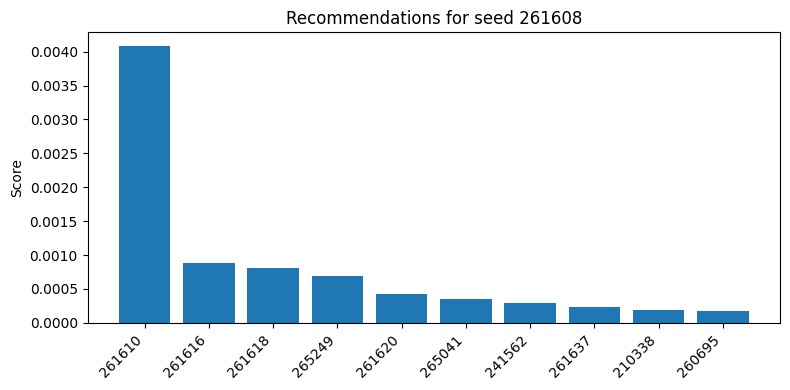

In [44]:
visualize_recs_for_single_item(seed_item=None, top_n=10)



1. **Time split:** for each user, keep their past purchases as **history** and hold out their **next purchase(s)**.
2. **Ask the model:** “Given this user’s history, **recommend Top-K items**.”

### Metrics

* **HitRate\@K / Recall\@K:** did any of the user’s held-out purchases show up in the Top-K?

  * One held-out item → HitRate\@K = Recall\@K (hit or miss).
  * Many held-out items → Recall\@K = (# test items covered) / (total test items).
* **Precision\@K:** of the Top-K shown, how many were actually bought in the test window?
* **NDCG\@K / MRR:** reward putting the true next purchase **higher** in the list.
* **Coverage/Diversity:** how much of the catalog ever gets recommended (not just best-sellers).


For each basket item, take its nearest neighbors from your precomputed item–item graph, sum/average the scores, remove items already in the basket, and show the top-K.
If the user has any past purchases once they log in, add those as extra seeds (optionally give higher weight to basket items for recency/context).


?? Is the approach of Top-n precision evaluation. In this plan we’ll use all customers who have at least 10 product purchases, and measure the top-3 precision of recommendations using a 5-fold cross-validation against a random 80% training/20% test set. We measure as a “hit” anything withheld from the test set. We will identify the best few algorithm candidates based on highest top-3 precision. 